In [1]:
import locale
locale.getpreferredencoding()

'UTF-8'

In [2]:
import numpy as np
import pandas as pd
import pathlib
import os
import sys
import glob
import tensorflow as tf
# from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Image, display
import cv2
import json
%matplotlib inline

In [28]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
print(tf.__version__)

2.0.0


## Preprocess data

In [4]:
data_path = "../data"
city = "gz"
meta_table = pd.read_csv("../_"+city+"_filename_dict.csv")

In [5]:
# Filter is_readable_image == False
f_table = meta_table[(meta_table['is_readable_image']) & (meta_table['is_completed_image'])].copy()
# f_table = f_table[f_table['_format'] != ".gif"].copy()
f_table.reset_index(drop=True, inplace=True)
f_table.fillna("", inplace=True)

In [8]:
# target_label = "sample"
target_label = "level0"
# target_label = "general_level0"
# filenames = ['../data/' + fname for fname in f_table['_filename'].tolist()]
filenames = [data_path + "/" +fname for fname in (f_table['city'] + "/" +f_table['_filename']).tolist()]
lv0_labels = f_table[target_label].tolist()

In [18]:
labelencoder = preprocessing.LabelEncoder()
lv0_labels_encoded = labelencoder.fit_transform(lv0_labels)
lv0_n_classes = len(labelencoder.classes_)
level0_label_dict = {k:v for k,v in enumerate(labelencoder.classes_)}
level0_labels = list(labelencoder.classes_)

In [19]:
level0_labels

['人像', '其他垃圾', '厨余垃圾', '可回收物', '有害垃圾']

In [9]:
image_df = pd.DataFrame({"image_file": filenames, "class": lv0_labels})

In [72]:
train_df, val_df, test_df = np.split(image_df.sample(frac=1), [int(.8*len(image_df)), int(.9*len(image_df))])

In [73]:
train_df.head()

,image_file,class
1045,../data/gz/厨余垃圾_肉蛋食品_豆制品_44.jpg,厨余垃圾
5036,../data/gz/其他垃圾_水果硬壳_粽子叶_25.jpg,其他垃圾
5007,../data/gz/人像_selfie_697.jpg,人像
4576,../data/gz/人像_selfie_952.jpg,人像
6,../data/gz/厨余垃圾_水培植物_水培植物_15.jpg,厨余垃圾


### HyParam

In [21]:
# basenetwork = "inception"
basenetwork = "mobilenet"

In [142]:
# Inception V3 299
if basenetwork == "inception":
    IMAGE_SIZE = 299
elif basenetwork == "mobilenet":
    IMAGE_SIZE = 224
# Mobilenet use 128
# IMAGE_SIZE = 128
BATCH_SIZE = 16
print(IMAGE_SIZE, BATCH_SIZE)

224 16


### Data pipeline

In [143]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

image_gen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [144]:
train_data_gen = image_gen_train.flow_from_dataframe(train_df
                                        , x_col='image_file'
                                        , y_col='class'
                                        , batch_size=BATCH_SIZE
                                        , target_size=(IMAGE_SIZE, IMAGE_SIZE)
                                        , classes=level0_labels
                                        , class_mode='categorical')
val_data_gen = image_gen_val.flow_from_dataframe(val_df
                                        , x_col='image_file'
                                        , y_col='class'
                                        , batch_size=BATCH_SIZE
                                        , target_size=(IMAGE_SIZE, IMAGE_SIZE)
                                        , classes=level0_labels
                                        , class_mode='categorical')

Found 6403 validated image filenames belonging to 5 classes.
Found 800 validated image filenames belonging to 5 classes.


In [145]:
# augmented_images = [train_data_gen[0][0][0] for i in range(5)]
# level0_labels
# len(lv0_labels)

In [146]:
# plotImages(augmented_images)

In [147]:
# a = [train_data_gen for i in range(5)]
# t = a[0]

In [148]:
# t.next()[1].shape

## Define the model

In [149]:
FINE_TUNE = True

In [150]:
# Base model with InceptionV3
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

if basenetwork == "inception":
    base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
elif basenetwork == "mobilenet":
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')



if FINE_TUNE:
    # Unfreeze all layers of MobileNetV2
    base_model.trainable = True

    # Refreeze layers until the layers we want to fine-tune
    for layer in base_model.layers[:75]:
        layer.trainable =  False
else:
    base_model.trainable = False

In [204]:
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
avgpool_layer = tf.keras.layers.GlobalAveragePooling2D()
# dense_layer = tf.keras.layers.Dense(1024, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(lv0_n_classes, activation='softmax')

learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model
    # mobilenetV2
    , avgpool_layer
    # , maxpool_layer
    # , dense_layer
    , dropout_layer
    , prediction_layer
])

# Now the optimizer is under tf.keras.
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
    # optimizer=tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    ## Onehot encoding use categorical_crossentropy
    # , loss='categorical_crossentropy'
    ## Integer encoding, use sparse_categorical_crossentropy
    # , loss='sparse_categorical_crossentropy'
    , loss='categorical_crossentropy'
    , metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,074,117
Non-trainable params: 190,272
_________________________________________________________________


## Train model

In [205]:
num_epochs = 15
steps_per_epoch = round(len(train_df))//BATCH_SIZE
# val_steps = 20
val_steps = round(len(val_df))//BATCH_SIZE
count = 0

In [206]:
count += 1
history = model.fit_generator(
    train_data_gen,
    epochs=num_epochs,
    steps_per_epoch = steps_per_epoch,
    validation_data=val_data_gen,
    validation_steps=val_steps
)



Epoch 1/15
 75/404 [====>.........................] - ETA: 1:16 - loss: 0.8035 - accuracy: 0.7192

/home/ccuulinay/anaconda3/envs/tf2_0/lib/python3.6/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


404/404 [==============================] - 97s 241ms/step - loss: 0.4617 - accuracy: 0.8365 - val_loss: 1.4968 - val_accuracy: 0.5938
Epoch 2/15
404/404 [==============================] - 97s 240ms/step - loss: 0.3119 - accuracy: 0.8892 - val_loss: 1.5043 - val_accuracy: 0.6400
Epoch 3/15
404/404 [==============================] - 97s 240ms/step - loss: 0.2920 - accuracy: 0.8929 - val_loss: 1.5333 - val_accuracy: 0.6363
Epoch 4/15
404/404 [==============================] - 97s 241ms/step - loss: 0.2857 - accuracy: 0.9002 - val_loss: 1.3294 - val_accuracy: 0.6775
Epoch 5/15
404/404 [==============================] - 98s 241ms/step - loss: 0.2682 - accuracy: 0.9014 - val_loss: 1.2365 - val_accuracy: 0.6812
Epoch 6/15
404/404 [==============================] - 98s 242ms/step - loss: 0.2597 - accuracy: 0.9071 - val_loss: 1.4317 - val_accuracy: 0.6650
Epoch 7/15
404/404 [==============================] - 98s 242ms/step - loss: 0.2452 - accuracy: 0.9120 - val_loss: 1.8191 - val_accuracy: 0.6

## Take a look

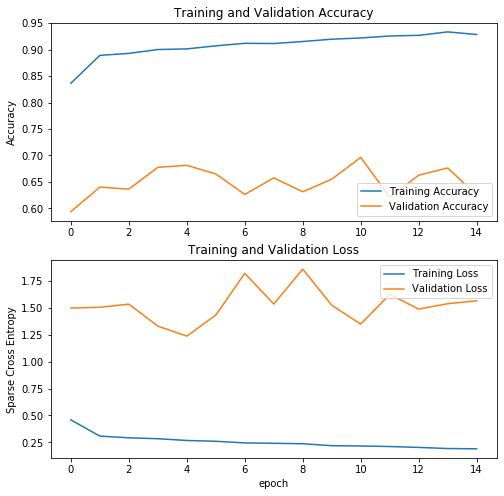

In [207]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Test

In [208]:
image_gen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_dataframe(
                                        dataframe=test_df
                                        , x_col='image_file'
                                        , y_col=None
                                        , batch_size=BATCH_SIZE
                                        , target_size=(IMAGE_SIZE, IMAGE_SIZE)
                                        , shuffle=False
                                        , class_mode=None
                                        , validate_filenames=False
)

Found 810 non-validated image filenames.


In [209]:
test_data_gen.reset()
STEP_SIZE_TEST = test_data_gen.n//test_data_gen.batch_size
pred = model.predict_generator(test_data_gen, steps=STEP_SIZE_TEST, verbose=1)

50/50 [==============================] - 5s 102ms/step


In [210]:
predicted_class_indices=np.argmax(pred,axis=1)

In [211]:
labels = (train_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [214]:
len(predictions)

800

In [203]:
test_df[
    ~((test_df['image_file'].str.endswith('png'))
    | (test_df['image_file'].str.endswith('jpg'))
    | (test_df['image_file'].str.endswith('jpeg'))
    | (test_df['image_file'].str.endswith('bmp'))
    | (test_df['image_file'].str.endswith('tif'))
    | (test_df['image_file'].str.endswith('tiff')))
        
       ]

,image_file,class
6562,../data/gz/可回收物_废纸类_报刊杂志_10.jpg!ww700,可回收物
2535,../data/gz/有害垃圾_废胶片及废相纸类_废相纸类_18.aspx,有害垃圾
7644,../data/gz/其他垃圾_废弃日用品_眼镜_47.jpg@768w_1l,其他垃圾
5438,../data/gz/其他垃圾_废弃日用品_木竹砧板_24.png@!800_w_db,其他垃圾
2894,../data/gz/厨余垃圾_糖果糕点_糕饼_5.jpg!560x350,厨余垃圾
483,../data/gz/可回收物_废玻璃_酒瓶_50.jpg-1440,可回收物
4975,../data/gz/其他垃圾_废弃日用品_LED灯_38.jpg-1440,其他垃圾
921,../data/gz/厨余垃圾_肉蛋食品_肉蛋食品_54.jpg!ww700,厨余垃圾
3203,../data/gz/有害垃圾_废胶片及废相纸类_废胶片_20.aspx,有害垃圾
899,../data/gz/有害垃圾_废化学品类_染发剂_14.png!sy,有害垃圾
